#1. Установка зависимостей и импорт библиотек

In [61]:
# Установка зависимостей
#!pip install supervision opencv-python pillow matplotlib
#!pip install inference-sdk

In [62]:
# Импорт необходимых библиотек
import cv2
import supervision as sv
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from collections import Counter # Импортируем Counter для подсчета классов

#2. Подготовка данных

In [63]:
# Ссылка на тестовое изображение лесного пожара.
# В реальном мониторинге здесь мог бы быть поток с камеры или путь к локальному файлу.
image_url = "https://github.com/DmitryMedvedkin/SF_Project_practice/blob/main/Тест_низовой_пожар_населённый_пункт.png?raw=true"

#3. Инициализация клиента Roboflow

In [64]:
# Создается экземпляр клиента для общения с Roboflow API.
# api_url указывает на серверлесс-инфраструктуру Roboflow.
# api_key (ваш API ключ) нужен для аутентификации запроса.
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="ВАШ_API_КЛЮЧ"
)

#4. Выполнение инференса (предсказания)

In [65]:
# client.run_workflow отправляет изображение на сервер для обработки.
# workspace_name="dmitry-s-workspace": имя рабочего пространства пользователя.
# workflow_id="find-smokes": конкретная версия модели/workflow, для обнаружения лесных пожаров (дыма).
# images: словарь с изображениями. В данном случае передается URL.
# use_cache=False: принудительно обновляет определение workflow (полезно при отладке).
result = client.run_workflow(
    workspace_name="dmitry-s-workspace",
    workflow_id="find-smokes-clouds-buildings-and-fires",
    images={
        "image": image_url
    },
    use_cache=False
)

#5. Загрузка и конвертация изображения

In [66]:
# Для визуализации нам нужно само изображение, а не ссылка.
# requests.get скачивает байты изображения.
response = requests.get(image_url)

# BytesIO превращает байты в файловый объект, понятный библиотеке PIL.
# .convert("RGB") гарантирует, что картинка будет в стандартном цветовом формате (без альфа-канала).
image = Image.open(BytesIO(response.content)).convert("RGB")

# Превращаем PIL-изображение в NumPy-массив, так как библиотека supervision и OpenCV работают с массивами.
image_np = np.array(image)

#6. Обработка результатов (Парсинг)

In [67]:
# Результат от API приходит в виде списка словарей (по одному на каждое отправленное изображение).
# Мы отправляли одно изображение, поэтому берем result[0].
prediction_data = result[0]

# Библиотека supervision (sv) значительно упрощает работу с результатами нейросетей.
# sv.Detections.from_inference автоматически разбирает сложный JSON-ответ от Roboflow.
# Он извлекает координаты рамок (bounding boxes), классы и уверенность модели.
# Важно: "predictions" - это ключ в словаре prediction_data, содержащий результаты детекции.
detections = sv.Detections.from_inference(prediction_data["predictions"])

#7. Настройка визуализации (Аннотаторы)

In [68]:
# BoxAnnotator отвечает за рисование прямоугольников вокруг найденных объектов.
box_annotator = sv.BoxAnnotator()

# LabelAnnotator отвечает за размещение текста (названия класса) над рамкой.
label_annotator = sv.LabelAnnotator(
    text_position=sv.Position.BOTTOM_LEFT
)

# Формирование списка подписей.
# zip(...) объединяет имена классов и уверенность модели для каждого обнаруженного объекта.
# f-строка форматирует текст: "smoke 0.56" (имя + уверенность с двумя знаками после запятых).
labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections.data["class_name"], detections.confidence)
]

#8. Отрисовка на изображении

In [73]:
# Сначала рисуем рамки на копии исходного изображения (image_np.copy()).
# Копия нужна, чтобы не "портить" исходный массив данных, если он понадобится позже чистым.
annotated_image = box_annotator.annotate(
    scene=image_np.copy(),
    detections=detections
)

# Затем поверх рамок добавляем текстовые метки, используя labels, созданные выше.
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

#9. Определение степени угрозы и вывод результатов с визуализацией

КРИТИЧЕСКАЯ ОПАСНОСТЬ
Низовой пожар: обнаружен дым (2), огонь не виден
   → Необходимо срочно потушить до перехода в верховой!
ОБНАРУЖЕНЫ СТРОЕНИЯ РЯДОМ (8 объект(ов))
   → НЕОБХОДИМА СРОЧНАЯ ЭВАКУАЦИЯ НАСЕЛЕНИЯ!
Дополнительная статистика:
Обнаружено объектов:
  • Дым: 2
  • Огонь: 0
  • Строения: 8


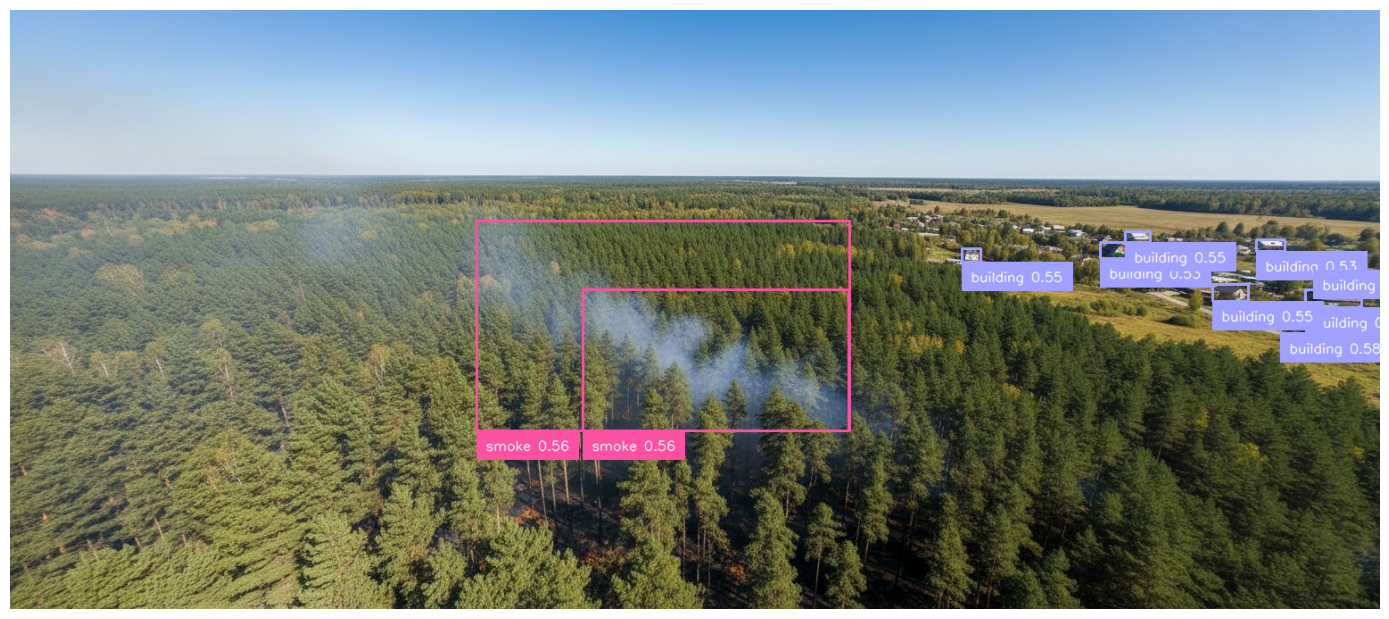

In [80]:
# 1. Получаем список полученных классов
class_names = detections.data["class_name"]
class_counts = {
    'smoke': sum(1 for name in class_names if name == "smoke"),
    'fire': sum(1 for name in class_names if name == "fire"),
    'building': sum(1 for name in class_names if name == "building")
}

# 2. Определяем уровень опасности
threat_level = "УГРОЗЫ НЕ ОБНАРУЖЕНО"
threat_description = []
threat_detected = False

# 3. Логика определения угрозы и формирование вывода
if class_counts['smoke'] > 0:
    threat_detected = True

    if class_counts['fire'] > 0:
        threat_level = "ВЕРХОВОЙ ПОЖАР - ВЫСОКАЯ ОПАСНОСТЬ"
        threat_description.append(f"Верховой пожар: обнаружены дым ({class_counts['smoke']}) и огонь ({class_counts['fire']})")
        threat_description.append("   → Быстрое распространение!")
        threat_description.append("   → ТРЕБУЕТСЯ СРОЧНОЕ ВМЕШАТЕЛЬСТВО")
    else:
        threat_level = "НИЗОВОЙ ПОЖАР - ТРЕБУЕТ СРОЧНОГО ТУШЕНИЯ"
        threat_description.append(f"Низовой пожар: обнаружен дым ({class_counts['smoke']}), огонь не виден")
        threat_description.append("   → Необходимо срочно потушить до перехода в верховой!")

    if class_counts['building'] > 0:
        threat_level = "КРИТИЧЕСКАЯ ОПАСНОСТЬ"
        threat_description.append(f"ОБНАРУЖЕНЫ СТРОЕНИЯ РЯДОМ ({class_counts['building']} объект(ов))")
        threat_description.append("   → НЕОБХОДИМА СРОЧНАЯ ЭВАКУАЦИЯ НАСЕЛЕНИЯ!")

else:
    threat_detected = False
    threat_description.append("Лесной пожар не обнаружен")

# 4. Вывод текстовой статистики
print("=" * 80)
print(threat_level)
print("=" * 80)
for line in threat_description:
    print(line)
print("=" * 80)
print("Дополнительная статистика:")
print("Обнаружено объектов:")
print(f"  • Дым: {class_counts['smoke']}")
print(f"  • Огонь: {class_counts['fire']}")
print(f"  • Строения: {class_counts['building']}")
print("=" * 80)

# 5. Используем Matplotlib для показа изображения прямо в Jupyter Notebook или окне IDE.
plt.figure(figsize=(14, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.tight_layout()
plt.show()